# Model Data

In [1]:
import numpy as np
import pandas as pd
import wrangle

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Acquire the data
events = wrangle.get_event_data()

In [3]:
events.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2932 entries, 2013-10-01 to 2021-10-10
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   intakes         2932 non-null   int64
 1   adoptions       2932 non-null   uint8
 2   deaths          2932 non-null   uint8
 3   euthanizations  2932 non-null   uint8
 4   rto             2932 non-null   uint8
 5   rto_adoptions   2932 non-null   uint8
 6   transfers       2932 non-null   uint8
dtypes: int64(1), uint8(6)
memory usage: 63.0 KB


<AxesSubplot:xlabel='Date'>

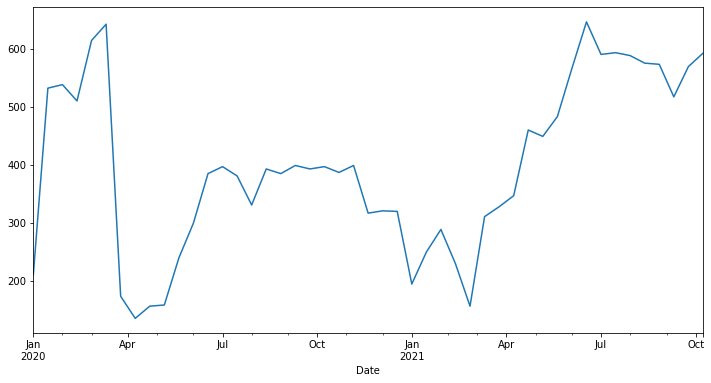

In [4]:
#For the MVP, I will be focusing on the intakes
events['2020':'2021'].intakes.resample('2W').sum().plot(figsize=(12,6))

Based on the above graph, I will set the validate data to the dates between Apr 2020 and Apr 2021. Test will be the dates from Apr 2021 to Oct 2021. Train, will be nearly everything before Apr 2020.

In [5]:
train = events['2014-04':'2020-03'].resample('M').sum()
train.shape

(72, 7)

In [6]:
validate = events['2020-04':'2021-03'].resample('M').sum()
validate.shape

(12, 7)

In [7]:
test = events['2021-04':'2021-10'].resample('M').sum()
test.shape

(7, 7)

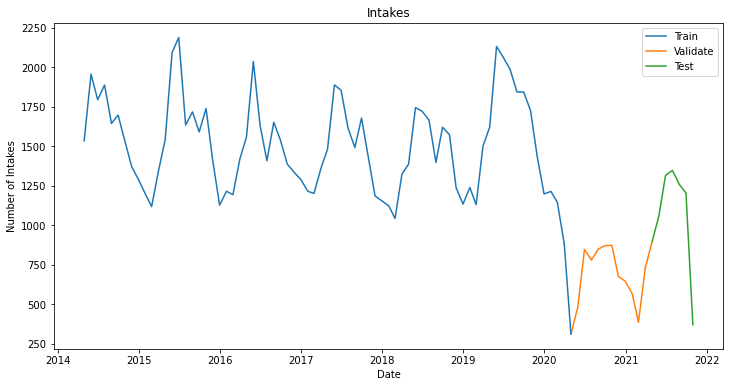

In [8]:
#Plot the data
plt.figure(figsize=(12,6))
plt.plot(train['intakes'], label = 'Train', color = '#1f77b4')
plt.plot(validate['intakes'], label = 'Validate', color = '#ff7f0e')
plt.plot(test['intakes'], label = 'Test', color = '#2ca02c')
#The following two plots fill in the gaps between each data set
plt.plot(events['2020-03':'2020-04']['intakes'].resample('M').sum(), color = '#1f77b4')
plt.plot(events['2021-03':'2021-04']['intakes'].resample('M').sum(), color = '#ff7f0e')
plt.title('Intakes')
plt.xlabel('Date')
plt.ylabel('Number of Intakes')
plt.legend()
plt.show()

Some Helpful Functions:

In [9]:
def evaluate(target_var):
    """
        This function will calculate the RMSE and return it.
    """
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [10]:
def plot_and_eval(target_var):
    """
        This function will use the evaluate function and also plot train 
        and test values with the predicted values in order to compare performance.
    """
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'Prediction', linewidth = 1)
    plt.title(target_var)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Number of Intakes')
    #The following plot fills in the gap between each data set
    plt.plot(events['2020-03':'2020-04']['intakes'].resample('M').sum(), color = '#1f77b4', linewidth = 1)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [11]:
#Create an evaluation dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    """
        This function will append evaluation metrics for each model type, target variable, 
        and metric type, along with the metric value into our eval_df data frame object. 
    """
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [12]:
def make_predictions():
    yhat_df = pd.DataFrame({'intakes': [intakes],
                           }, index = validate.index)
    return yhat_df

### Simple Average

In [13]:
#Find the average
intakes = round(train.intakes.mean(), 2)

In [14]:
yhat_df = make_predictions()

intakes -- RMSE: 860


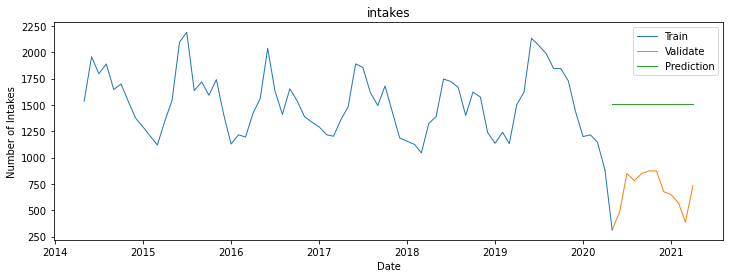

In [15]:
plot_and_eval('intakes')

In [16]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = 'intakes')

In [17]:
eval_df

,model_type,target_var,rmse
0,simple_average,intakes,860.0


### Moving Average

Use a loop to create several moving average models.

In [18]:
periods = [1, 3, 6, 9, 12]

for p in periods:
    intakes = round(train['intakes'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'm moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'intakes'
                            )

In [19]:
eval_df

,model_type,target_var,rmse
0,simple_average,intakes,860.0
1,1m moving average,intakes,283.0
2,3m moving average,intakes,452.0
3,6m moving average,intakes,626.0
4,9m moving average,intakes,828.0
5,12m moving average,intakes,941.0


In [108]:
model = Holt(train['intakes'], exponential = False)
model = model.fit(smoothing_level = .05, 
                  smoothing_slope = .11, 
                  optimized = False)
yhat_counts = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['intakes'] = round(yhat_counts, 2)

intakes -- RMSE: 187


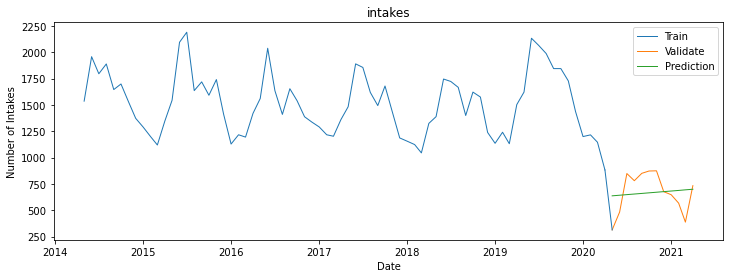

In [109]:
plot_and_eval('intakes')

In [22]:
eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = 'intakes')

In [23]:
eval_df

,model_type,target_var,rmse
0,simple_average,intakes,860.0
1,1m moving average,intakes,283.0
2,3m moving average,intakes,452.0
3,6m moving average,intakes,626.0
4,9m moving average,intakes,828.0
5,12m moving average,intakes,941.0
6,Holts,intakes,187.0


### Predict Using the Previous Cycles

In [24]:
#Add the average yearly difference to the last year's values in train
yhat_df = train['2019-04':'2020-03'] + train.diff(12).mean()

In [25]:
# set yhat_df to index of validate
yhat_df.index = validate.index

intakes -- RMSE: 1008


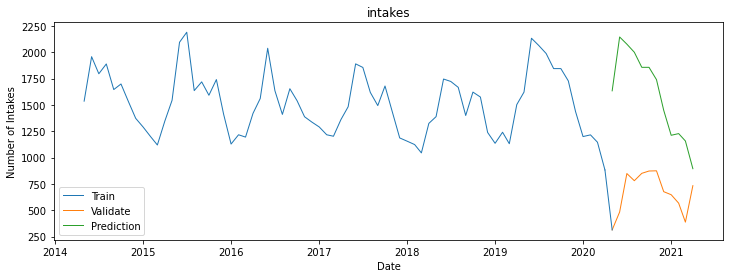

In [26]:
plot_and_eval('intakes')
eval_df = append_eval_df(model_type = 'previous year', target_var = 'intakes')

In [27]:
eval_df

,model_type,target_var,rmse
0,simple_average,intakes,860.0
1,1m moving average,intakes,283.0
2,3m moving average,intakes,452.0
3,6m moving average,intakes,626.0
4,9m moving average,intakes,828.0
5,12m moving average,intakes,941.0
6,Holts,intakes,187.0
7,previous year,intakes,1008.0


### Including a delta 

In [28]:
#Now compute the yearly differences to find the drop off amount for the last year
#Then add that amount to your predictions and see how it does
year_deltas = train.resample('Y').mean().diff().intakes
year_deltas

Date
2014-12-31           NaN
2015-12-31    -75.000000
2016-12-31    -86.416667
2017-12-31     -9.333333
2018-12-31    -48.666667
2019-12-31    229.000000
2020-12-31   -563.250000
Freq: A-DEC, Name: intakes, dtype: float64

In [33]:
drop_off = -563

In [34]:
#Add the average yearly difference to the last year's values in train and add the delta
yhat_df = train['2019-04':'2020-03'] + train.diff(12).mean() + drop_off

In [35]:
# set yhat_df to index of validate
yhat_df.index = validate.index

intakes -- RMSE: 530


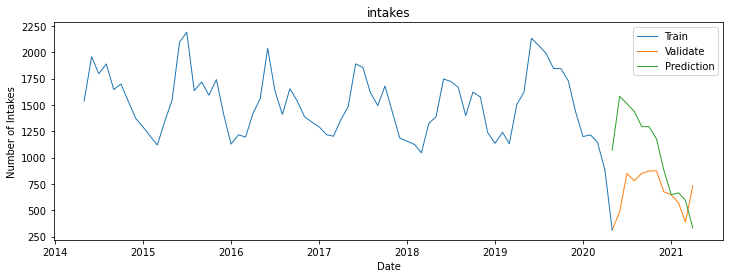

In [36]:
plot_and_eval('intakes')
eval_df = append_eval_df(model_type = 'previous year plus delta', target_var = 'intakes')

In [37]:
eval_df

,model_type,target_var,rmse
0,simple_average,intakes,860.0
1,1m moving average,intakes,283.0
2,3m moving average,intakes,452.0
3,6m moving average,intakes,626.0
4,9m moving average,intakes,828.0
5,12m moving average,intakes,941.0
6,Holts,intakes,187.0
7,previous year,intakes,1008.0
8,previous year plus delta,intakes,530.0


It seems that the Holts model is the best one so far. I will evaluate it on the unseen test data set in the final report notebook.